In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/fractaluser/Downloads/prototype')
from keras.layers import Input, Dense
from keras.models import Model
from keras import callbacks
import time, random
import scipy
import seaborn as sns
sns.set(palette='dark', font_scale = 1)
pd.set_option('display.max_columns', None)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.seed(216)
from tensorflow import set_random_seed

sample_data = pd.read_csv('sample_simulated_transaction_history.csv')
sample_data.date = pd.to_datetime(sample_data.date)

In [3]:
sample_data.head()

,id,date,purchaseamount,dept,category,chain,purchasequantity,company,brand,productsize,productmeasure
0,Donor_1,2015-03-04,203.174075,Sports,Sports,site_1,1,Company1,Brand3,x,xx
1,Donor_1,2016-04-17,300.639489,Sports,Sports,site_1,1,Company1,Brand1,x,xx
2,Donor_1,2015-04-06,374.096413,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand1,x,xx
3,Donor_1,2015-09-04,348.347601,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand3,x,xx
4,Donor_1,2016-03-08,287.477333,Women Apparel,Dresses/Jumpsuits,site_1,1,Company1,Brand3,x,xx


In [4]:
df = sample_data[(sample_data.category == 'Tees & Polos')].reset_index(drop = True)[['id','date', 'purchaseamount']]
df = df.pivot_table(index=['id'], columns='date', values='purchaseamount', aggfunc='mean').fillna(0).T

In [5]:
pre_start_date = '2015-01-01'
pre_end_date = '2015-12-31'

In [6]:
df['dummy_donor_1'] = pd.DataFrame({'dummy_donor_1':df.iloc[:,-1].shift()})
df['dummy_donor_2'] = pd.DataFrame({'dummy_donor_2':df.iloc[:,-2].shift(-1)})
df['dummy_donor_3'] = pd.DataFrame({'dummy_donor_3':df.iloc[:,-3]*1.7})
df = df.fillna(0)

In [7]:
xtrain1 = df[pre_start_date:pre_end_date][df.columns[:5000]].values.T
xtest1 = df[pre_start_date:pre_end_date][df.columns[5000:]].values.T

In [8]:
columns = (xtrain1 == 0).sum(0)
rows = (xtrain1 == 0).sum(1)
print(rows.sum()*100/(xtrain1.shape[0]*xtrain1.shape[1]))

96.51298630136986


In [9]:
columns = (xtest1 == 0).sum(0)
rows = (xtest1 == 0).sum(1)
print(rows.sum()*100/(xtest1.shape[0]*xtest1.shape[1]))

96.52494571081277


In [10]:
DIM = 70

encoding_dim1 = DIM*5
encoding_dim2 = DIM*4
encoding_dim3 = DIM*3
encoding_dim4 = DIM

In [11]:
inputs = Input(shape=(xtrain1.shape[1],))

encoded1 = Dense(encoding_dim1, activation='tanh')(inputs)
encoded2 = Dense(encoding_dim2, activation='tanh')(encoded1)
encoded3 = Dense(encoding_dim3, activation='tanh')(encoded2)
encoded4 = Dense(encoding_dim4, activation='tanh')(encoded3)
decoded1 = Dense(encoding_dim3, activation='tanh')(encoded4)
decoded2 = Dense(encoding_dim2, activation='tanh')(decoded1)
decoded3 = Dense(encoding_dim1, activation='relu')(decoded2)
decoded4 = Dense(xtrain1.shape[1], activation='relu')(decoded3)

autoencoder = Model(inputs, decoded4)
encoder = Model(inputs, encoded4)
hidden_1 = Model(inputs, encoded1)
hidden_2 = Model(inputs, encoded2)
hidden_3 = Model(inputs, encoded3)

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 365)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 350)               128100    
_________________________________________________________________
dense_2 (Dense)              (None, 280)               98280     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               59010     
_________________________________________________________________
dense_4 (Dense)              (None, 70)                14770     
_________________________________________________________________
dense_5 (Dense)              (None, 210)               14910     
_________________________________________________________________
dense_6 (Dense)              (None, 280)               59080     
__________

In [13]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 365)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 350)               128100    
_________________________________________________________________
dense_2 (Dense)              (None, 280)               98280     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               59010     
_________________________________________________________________
dense_4 (Dense)              (None, 70)                14770     
Total params: 300,160
Trainable params: 300,160
Non-trainable params: 0
_________________________________________________________________


In [14]:
set_random_seed(216)
EPOCHS = 1000
BATCH_SIZE = 500
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(xtrain1, xtrain1, epochs=EPOCHS, verbose = 1, batch_size=BATCH_SIZE, shuffle=True,
                  callbacks = [callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto')], validation_data = (xtest1, xtest1))

Train on 5000 samples, validate on 1003 samples
Epoch 1/1000
5000/5000 [==============================] - 2s 359us/step - loss: 32.4182 - val_loss: 31.6973
Epoch 2/1000
5000/5000 [==============================] - 1s 156us/step - loss: 31.4811 - val_loss: 31.1007
Epoch 3/1000
5000/5000 [==============================] - 1s 157us/step - loss: 30.8270 - val_loss: 30.4734
Epoch 4/1000
5000/5000 [==============================] - 1s 153us/step - loss: 30.0919 - val_loss: 29.7133
Epoch 5/1000
5000/5000 [==============================] - 1s 151us/step - loss: 29.1992 - val_loss: 28.8372
Epoch 6/1000
5000/5000 [==============================] - 1s 154us/step - loss: 28.2206 - val_loss: 27.9473
Epoch 7/1000
5000/5000 [==============================] - 1s 150us/step - loss: 27.2095 - val_loss: 27.0587
Epoch 8/1000
5000/5000 [==============================] - 1s 157us/step - loss: 26.1968 - val_loss: 26.1698
Epoch 9/1000
5000/5000 [==============================] - 1s 157us/step - loss: 25.1975 

5000/5000 [==============================] - 1s 174us/step - loss: 5.4161 - val_loss: 12.2512
Epoch 77/1000
5000/5000 [==============================] - 1s 145us/step - loss: 5.3837 - val_loss: 12.2957
Epoch 78/1000
5000/5000 [==============================] - 1s 148us/step - loss: 5.3493 - val_loss: 12.2849
Epoch 79/1000
5000/5000 [==============================] - 1s 148us/step - loss: 5.3228 - val_loss: 12.3211
Epoch 80/1000
5000/5000 [==============================] - 1s 147us/step - loss: 5.3059 - val_loss: 12.2826
Epoch 81/1000
5000/5000 [==============================] - 1s 159us/step - loss: 5.2730 - val_loss: 12.3399
Epoch 82/1000
5000/5000 [==============================] - 1s 147us/step - loss: 5.2505 - val_loss: 12.2647
Epoch 83/1000
5000/5000 [==============================] - 1s 165us/step - loss: 5.2228 - val_loss: 12.3428
Epoch 84/1000
5000/5000 [==============================] - 1s 148us/step - loss: 5.2085 - val_loss: 12.2741
Epoch 85/1000
5000/5000 [=================

5000/5000 [==============================] - 1s 147us/step - loss: 4.3411 - val_loss: 12.3500
Epoch 152/1000
5000/5000 [==============================] - 1s 146us/step - loss: 4.3263 - val_loss: 12.3582
Epoch 153/1000
5000/5000 [==============================] - 1s 148us/step - loss: 4.3233 - val_loss: 12.3001
Epoch 154/1000
5000/5000 [==============================] - 1s 151us/step - loss: 4.3145 - val_loss: 12.3279
Epoch 155/1000
5000/5000 [==============================] - 1s 172us/step - loss: 4.3064 - val_loss: 12.3335
Epoch 156/1000
5000/5000 [==============================] - 1s 144us/step - loss: 4.3007 - val_loss: 12.3671
Epoch 157/1000
5000/5000 [==============================] - 1s 148us/step - loss: 4.2967 - val_loss: 12.3292
Epoch 158/1000
5000/5000 [==============================] - 1s 147us/step - loss: 4.2923 - val_loss: 12.3210
Epoch 159/1000
5000/5000 [==============================] - 1s 184us/step - loss: 4.2933 - val_loss: 12.3654
Epoch 160/1000
5000/5000 [========

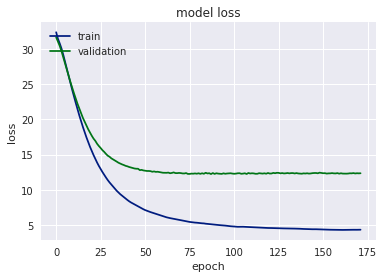

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

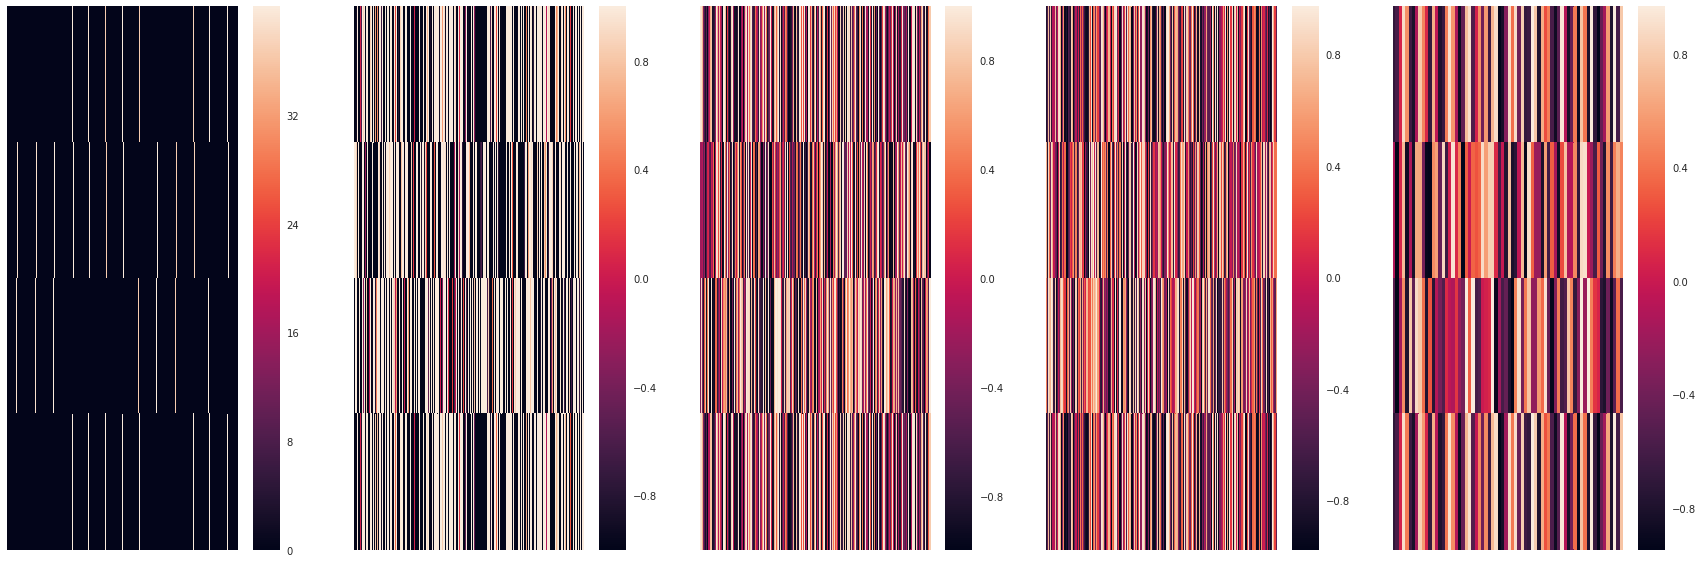

In [16]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, sharey=True, figsize = (30,10))
sns.heatmap(xtest1[-4:], xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax1)
sns.heatmap(hidden_1.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax2)
sns.heatmap(hidden_2.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax3)
sns.heatmap(hidden_3.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax4)
sns.heatmap(encoder.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax5)
plt.show()

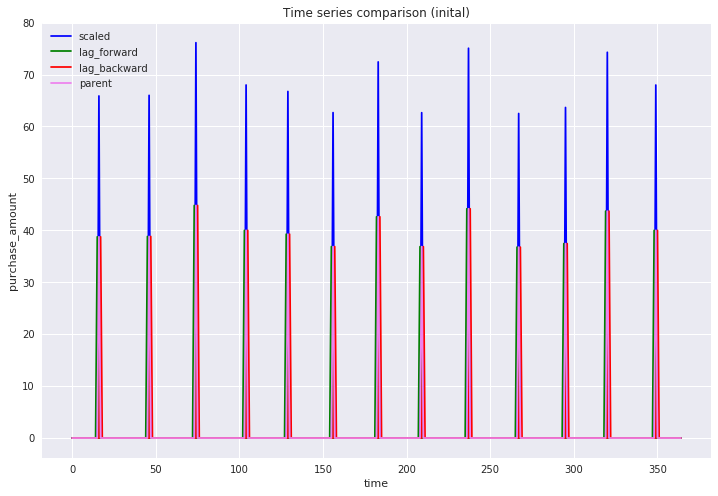

In [17]:
plt.figure(figsize = (12,8))
plt.plot(xtest1[-1], color = 'blue', label = 'scaled')
plt.plot(xtest1[-2], color = 'green', label = 'lag_forward')
plt.plot(xtest1[-3], color = 'red', label = 'lag_backward')
plt.plot(xtest1[-4], color = 'violet', label = 'parent')
plt.title('Time series comparison (inital)')
plt.legend(loc = 'best')
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [18]:
encoded_mat = encoder.predict(xtrain1)
encoded_mat_test = encoder.predict(xtest1)

decoded_mat = autoencoder.predict(xtrain1)
decoded_mat_test = autoencoder.predict(xtest1)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


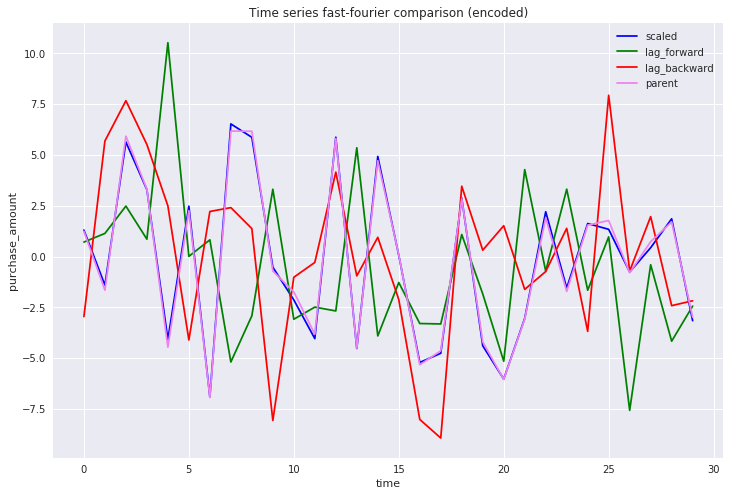

In [19]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(encoded_mat_test[-1])[-30:], color = 'blue', label = 'scaled')
plt.plot(np.fft.fft(encoded_mat_test[-2])[-30:], color = 'green', label = 'lag_forward')
plt.plot(np.fft.fft(encoded_mat_test[-3])[-30:], color = 'red', label = 'lag_backward')
plt.plot(np.fft.fft(encoded_mat_test[-4])[-30:], color = 'violet', label = 'parent')
plt.title('Time series fast-fourier comparison (encoded)')
plt.legend(loc='best')
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [20]:
encoded_df = pd.DataFrame(encoded_mat)
encoded_df.insert(loc=0, column='id', value=df.columns[:5000].values)
encoded_df = encoded_df.set_index(encoded_df.id).drop(labels = ['id'], axis = 1)
encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.196805,0.800265,0.401111,-0.655398,0.676448,-0.980130,0.912259,0.865054,0.968617,0.154795,-0.745973,-0.340560,-0.300594,-0.750443,-0.255114,0.896492,0.226397,-0.454515,-0.106899,-0.535121,-0.340517,0.937860,-0.335520,-0.114612,0.610419,0.823134,-0.791326,-0.640835,0.304712,0.940169,-0.792073,0.418651,-0.030193,-0.135582,0.322499,0.649623,0.890016,0.525800,0.745744,0.153890,0.863775,0.894220,0.920206,0.639163,-0.966929,0.510959,-0.688889,0.950478,0.804279,0.397701,-0.886178,0.589865,0.557541,-0.126167,-0.731605,-0.588546,0.775434,-0.445663,0.344371,0.503999,0.329876,-0.470895,-0.732689,-0.306753,-0.291214,0.881109,-0.967460,0.207139,0.525013,-0.012487
Donor_100,-0.124081,-0.867753,0.445240,-0.799864,-0.677276,0.296371,-0.940299,-0.747149,0.796409,0.824335,-0.713781,0.679952,-0.405602,0.655468,-0.739163,-0.904932,-0.264594,-0.694632,-0.540391,-0.113697,-0.638526,-0.980660,-0.100861,0.607448,0.470886,-0.045297,-0.912974,0.373225,-0.639257,-0.686193,0.259629,-0.131735,0.815732,0.305211,0.387164,-0.512822,-0.403258,0.387142,-0.604324,0.317399,-0.670897,0.123441,0.741509,0.499165,-0.533850,-0.840215,0.767447,-0.124594,0.897606,-0.366277,-0.242207,0.725096,-0.512053,0.880786,-0.233016,-0.941557,0.844664,-0.874297,0.816177,-0.198417,0.840514,-0.570813,0.851933,0.659142,0.819036,-0.939515,0.461025,0.398597,0.526094,-0.957520
Donor_1000,0.060960,-0.600499,0.693617,-0.688172,0.518901,-0.757619,-0.991732,0.545960,-0.580114,0.948837,0.484612,-0.338144,0.634500,0.314413,0.486143,-0.534841,0.213941,-0.383076,0.579762,0.541482,0.739800,-0.847444,-0.428367,0.508567,0.218071,0.681140,-0.194304,0.933417,0.545209,0.383900,0.742172,-0.049666,0.177542,0.662945,0.538363,0.801857,0.412627,-0.038768,-0.291023,-0.686798,-0.647716,0.787556,0.580692,0.926559,0.844317,-0.800451,-0.450933,-0.505287,-0.635701,-0.661440,0.873834,-0.425817,-0.218505,0.807793,0.820967,-0.116809,0.227588,-0.670102,0.831984,0.671835,0.428125,-0.929096,0.263561,-0.953395,0.741649,-0.929009,-0.759458,-0.774592,-0.832732,-0.772801
Donor_1001,0.881443,-0.916488,-0.949031,0.520002,-0.934587,0.667749,0.475351,0.690064,-0.808264,-0.835509,-0.976976,0.412255,-0.851308,0.946093,0.369780,-0.679271,0.262768,0.346628,0.629207,0.738652,-0.593887,0.328261,-0.208269,-0.044764,-0.765944,0.476907,0.911429,0.962510,0.493151,0.768203,0.598911,0.568327,0.256063,-0.487593,-0.617346,-0.599088,0.449104,0.183918,-0.794263,-0.934464,-0.784761,0.868633,-0.760600,0.754964,-0.212531,-0.783229,0.215452,-0.623840,0.644436,0.001170,0.600178,0.950993,0.924385,0.964361,0.419964,0.642373,0.579949,0.201184,-0.710030,-0.443276,-0.383228,-0.619648,0.865746,0.925997,-0.051719,-0.900863,-0.719136,0.036379,-0.455375,-0.576774
Donor_1002,0.067788,0.384807,0.884560,0.901067,0.197007,-0.801890,-0.332314,-0.283520,0.540950,-0.840358,0.665678,0.021907,-0.821556,0.470170,-0.657716,-0.169062,0.162629,0.736777,-0.636967,0.560450,-0.041969,0.505986,0.836051,0.503701,0.099702,-0.840037,0.213458,0.587633,0.546867,-0.567309,0.706104,-0.989552,0.229273,-0.975344,0.027464,0.992535,0.401078,0.361110,-0.051340,0.752020,0.926007,-0.862923,-0.460859,-0.054837,0.913103,0.164538,-0.232452,-0.487174,-0.885072,-0.405649,-0.084472,-0.733577,0.483010,0.530623,0.813018,-0.773561,0.290462,0.695184,0.208941,-0.814427,-0.572561,0.509644,-0.498716,-0.788718,-0.216596,-0.703903,0.223801,-0.762254,0.833420,-0.464426


In [21]:
encoded_df_test = pd.DataFrame(encoded_mat_test)
encoded_df_test.insert(loc=0, column='id', value=df.columns[5000:].values)
encoded_df_test = encoded_df_test.set_index(encoded_df_test.id).drop(labels = ['id'], axis = 1)
encoded_df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,0.244338,0.866169,-0.678921,-0.988527,0.533529,0.423883,-0.302149,-0.988978,-0.110799,0.174378,-0.768609,0.485632,-0.027363,0.811974,-0.643832,0.825474,0.670559,0.852515,-0.894422,0.199643,0.537305,-0.303518,-0.624584,0.724894,-0.535807,0.372248,0.870507,-0.494578,0.064400,0.948014,0.708752,-0.329540,0.824012,0.752438,0.715989,0.354514,0.823543,0.502081,0.716822,0.886325,-0.490192,-0.387375,0.605768,-0.739710,-0.703848,-0.919127,-0.130716,0.907333,0.909796,-0.317512,-0.988839,0.692681,0.868297,-0.968709,0.501512,-0.275204,-0.699816,0.714172,-0.602039,-0.386021,-0.781415,0.525034,-0.697501,0.399043,-0.052126,-0.453191,-0.360380,0.713692,-0.701453,0.021761
Test_145,-0.346964,-0.790970,-0.947109,-0.632060,0.696366,-0.418722,-0.532623,0.230406,-0.901142,0.486569,-0.948967,-0.365482,-0.502917,0.960171,-0.104022,-0.529520,0.493697,-0.679499,-0.636107,0.307006,-0.245850,-0.918631,0.865849,0.780556,0.885463,-0.160572,0.449529,-0.582422,0.666717,0.977040,0.714341,0.428747,-0.254313,-0.446012,-0.673535,0.382255,0.611973,0.397099,0.259196,-0.455910,-0.378743,0.078844,-0.792126,-0.766783,0.348890,-0.807502,0.910831,-0.955974,0.308950,0.369893,-0.935957,-0.045258,-0.614965,0.560089,-0.373665,-0.382481,0.052805,0.929713,-0.024171,0.246027,-0.835082,-0.829121,-0.756998,-0.267323,-0.372356,-0.349481,-0.558145,-0.260288,0.682609,-0.627329
Test_1450,0.394153,-0.398903,-0.553013,0.910413,0.418529,0.690447,0.122104,0.950522,-0.003152,-0.523905,0.525514,-0.923994,0.879950,-0.411215,0.061367,0.467799,-0.563072,-0.414559,0.626242,0.746413,-0.278604,0.714705,0.820900,0.465267,-0.374677,0.777261,-0.879398,0.961346,-0.892620,-0.356237,0.766493,0.964931,-0.294371,0.891358,-0.014029,0.892462,0.816130,-0.593626,0.134380,0.738758,0.047044,0.925783,-0.843276,0.954106,0.073596,0.781545,-0.764669,0.435101,-0.745673,0.779622,-0.756885,-0.576223,0.019167,-0.359880,0.092406,0.643796,-0.718054,-0.674338,0.059151,-0.549333,0.483146,-0.762264,-0.455455,-0.273315,-0.479311,-0.027283,0.897348,0.093402,-0.734470,0.915515
Test_1451,-0.275096,-0.867991,0.340045,-0.921941,-0.264673,0.109124,0.743249,-0.881841,-0.371794,-0.947652,0.393024,0.423299,-0.096764,-0.906286,0.621924,0.148673,-0.243993,-0.086775,0.052413,0.976586,0.191416,0.912043,-0.446629,0.510276,-0.421488,-0.096864,-0.070771,0.458515,-0.819755,-0.327387,-0.599518,0.822848,-0.063380,0.335136,0.700860,-0.247737,0.706185,0.276451,-0.292209,-0.138167,0.741490,-0.887625,-0.604040,0.503082,-0.798974,-0.162023,0.072205,0.910827,0.483057,-0.855842,-0.097248,-0.884224,-0.812406,-0.553145,-0.440770,-0.925614,-0.276950,-0.017281,-0.113926,-0.329656,0.777996,0.192579,-0.956166,-0.991357,-0.736192,-0.068383,0.933761,-0.444577,0.088518,-0.021645
Test_1452,-0.592325,0.082786,-0.203465,-0.342450,-0.926635,-0.049981,0.221606,0.805404,-0.528951,0.626515,0.676509,0.920603,-0.966104,-0.599201,0.506419,-0.801306,0.568794,0.678803,0.467046,0.585638,0.194739,0.604547,-0.630909,-0.658641,-0.464589,-0.075619,0.939371,0.442482,0.441444,-0.717932,-0.820253,0.364152,-0.641767,-0.946846,0.720265,-0.975953,-0.789213,0.941464,-0.841175,-0.800475,-0.981561,-0.918526,-0.651123,-0.403441,-0.187385,-0.856286,0.941993,-0.693986,0.389465,-0.852085,-0.366653,-0.003098,-0.652137,0.605351,-0.421152,-0.773875,0.837468,0.788707,-0.898464,-0.486396,0.034813,-0.531729,-0.618907,0.810321,-0.781942,-0.149802,-0.524473,0.393254,0.211671,-0.413704


In [22]:
xtrain = pd.DataFrame(xtrain1)
average_initial = xtrain.mean(axis = 0)
xtrain.insert(loc = 0, column = 'id', value = df.columns[:5000].values)
xtrain = xtrain.set_index(xtrain.id).drop(labels = ['id'], axis = 1)
xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.0,0.0,0.0,0.0,0.0,0.0,28.103086,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,25.465567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,29.395883,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.681370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,28.54345,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,28.002926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,27.025801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.822557,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,30.611507,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.675734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.815237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.406283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,29.19701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,32.555135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Donor_100,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,15.523447,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,21.602001,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.930828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,

In [23]:
comparison = pd.DataFrame(decoded_mat)
average_decoded = comparison.mean(axis = 0)
comparison.insert(loc = 0, column = 'id', value = df.columns[:5000].values)
comparison = comparison.set_index(comparison.id).drop(labels = ['id'], axis = 1)
comparison.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.0,0.000000,0.000000,0.0,0.0,0.0,27.559595,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.259442,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,32.189041,0.0,0.0,0.000000,2.790593,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,30.524654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,25.107618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.984463,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,33.055691,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.704998,0.0,0.0,28.968428,0.0,0.0,0.0,1.491533,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,26.147686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.11532,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,30.938986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,31.114866,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Donor_100,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,19.659237,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.26236,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,

In [24]:
xtest = pd.DataFrame(xtest1)
average_initial_test = xtest.mean(axis = 0)
xtest.insert(loc = 0, column = 'id', value = df.columns[5000:].values)
xtest = xtest.set_index(xtest.id).drop(labels = ['id'], axis = 1)
xtest.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,34.0962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,27.922484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,32.689643,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,32.538395,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,31.536311,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,31.296507,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,32.473824,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,25.174308,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,27.997594,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,32.697277,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,33.582588,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.953825,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.773184,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.259073
Test_145,0.0,0.0,43.088934,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,43.384996,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,40.449101,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.

In [25]:
comparison_test = pd.DataFrame(decoded_mat_test)
average_decoded_test = comparison_test.mean(axis = 0)
comparison_test.insert(loc = 0, column = 'id', value = df.columns[5000:].values)
comparison_test = comparison_test.set_index(comparison_test.id).drop(labels = ['id'], axis = 1)
comparison_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,23.462132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.451059,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,6.785737,12.979292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521598,0.0,19.008881,0.000000,0.0,0.0,26.705873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.10676,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.025963,0.0,0.0,0.0,0.0,0.0,0.0,1.346005,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,7.415808,0.0,0.0,0.0,0.0,61.69614,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,60.054516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,53.515354,0.0,18.347746,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,12.220668,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,22.520248,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,44.362885,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,7.785596,0.0,4.044313,11.127501,0.0,0.0,0.0,0.0,0.0,0.0,22.286572,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,12.119837,10.667418,0.0,0.0,22.633608,0.0,0.0,0.0,0.0,0.000000,2.999812,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.72884
Test_145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.121277,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,35.894638,0.0,5.449785,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,7.873550,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

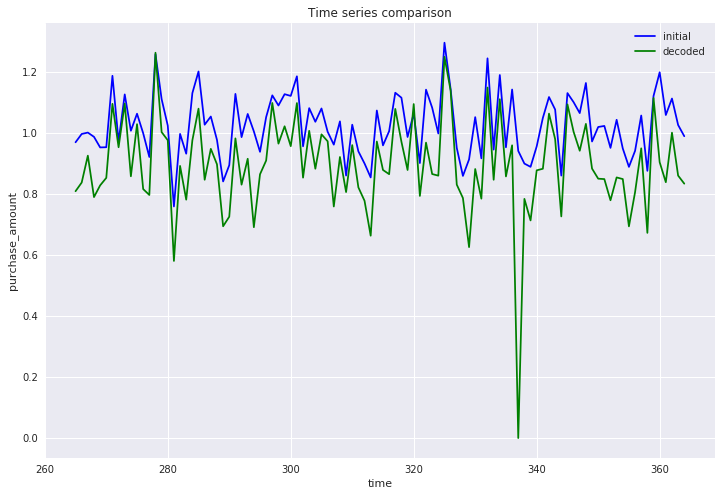

In [26]:
plt.figure(figsize = (12,8))
plt.plot(average_initial[-100:], color = 'blue', label = 'initial')
plt.plot(average_decoded[-100:], color = 'green', label = 'decoded')
plt.title('Time series comparison')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


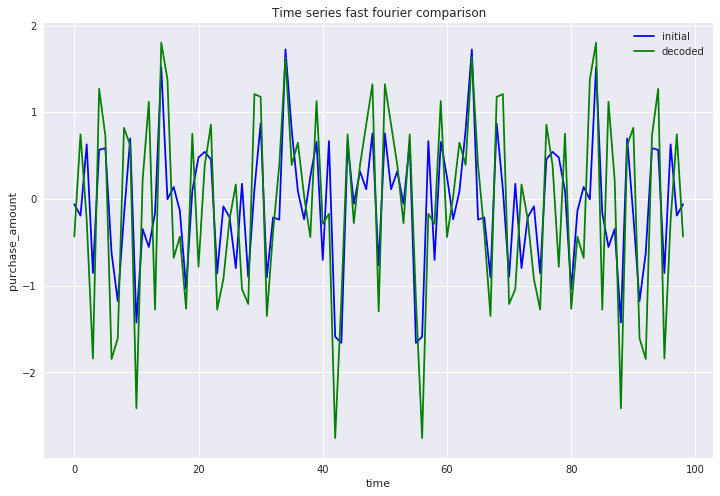

In [27]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(average_initial[-100:])[1:], color = 'blue', label = 'initial')
plt.plot(np.fft.fft(average_decoded[-100:])[1:], color = 'green', label = 'decoded')
plt.title('Time series fast fourier comparison')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

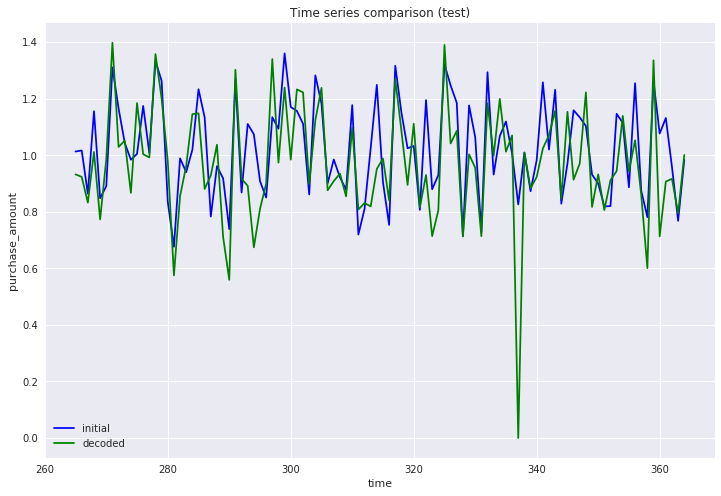

In [28]:
plt.figure(figsize = (12,8))
plt.plot(average_initial_test[-100:], color = 'blue', label = 'initial')
plt.plot(average_decoded_test[-100:], color = 'green', label = 'decoded')
plt.title('Time series comparison (test)')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


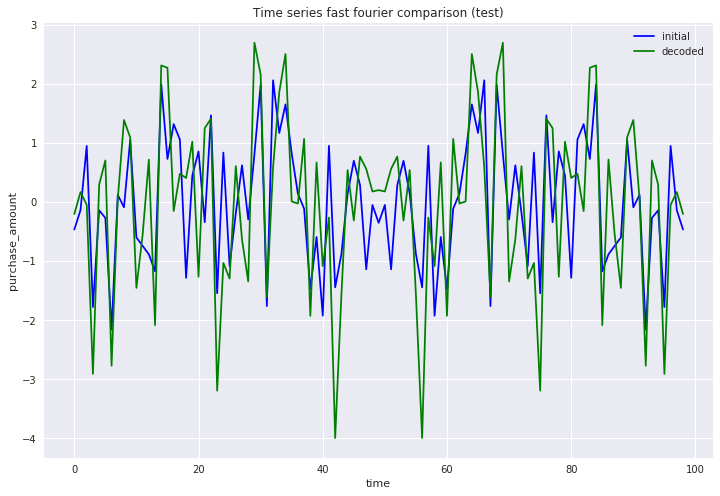

In [29]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(average_initial_test[-100:])[1:], color = 'blue', label = 'initial')
plt.plot(np.fft.fft(average_decoded_test[-100:])[1:], color = 'green', label = 'decoded')
plt.title('Time series fast fourier comparison (test)')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [30]:
binary_xtrain = np.where(xtrain>0, 1, 0)
binary_decoded_mat = np.where(decoded_mat>0,1,0)

binary_xtest = np.where(xtest>0, 1, 0)
binary_decoded_mat_test = np.where(decoded_mat_test>0,1,0)

In [31]:
print('Percent similarity', 100 - (abs(np.linalg.norm(xtrain)-np.linalg.norm(decoded_mat))*100/min(np.linalg.norm(xtrain), np.linalg.norm(decoded_mat))))
print('Percent similarity binary', 100 - (abs(np.linalg.norm(binary_xtrain)-np.linalg.norm(binary_decoded_mat))*100/min(np.linalg.norm(binary_xtrain), np.linalg.norm(binary_decoded_mat))))

Percent similarity 92.54588268921579
Percent similarity binary 94.80330799736653


In [32]:
print('Percent similarity', 100 - (abs(np.linalg.norm(xtest)-np.linalg.norm(decoded_mat_test))*100/min(np.linalg.norm(xtest), np.linalg.norm(decoded_mat_test))))
print('Percent similarity binary', 100 - (abs(np.linalg.norm(binary_xtest)-np.linalg.norm(binary_decoded_mat_test))*100/min(np.linalg.norm(binary_xtest), np.linalg.norm(binary_decoded_mat_test))))

Percent similarity 96.84935198588873
Percent similarity binary 86.03279499342845


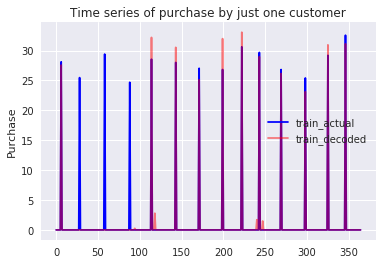

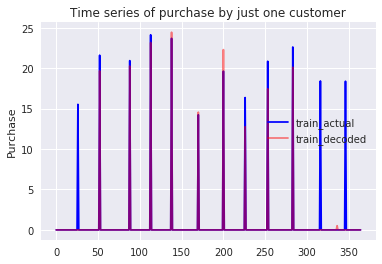

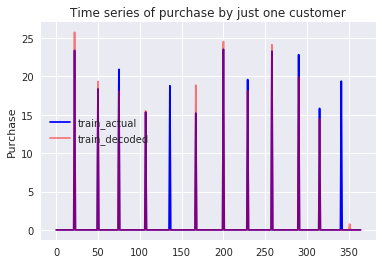

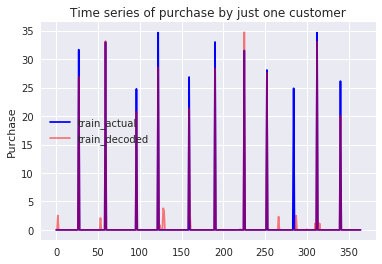

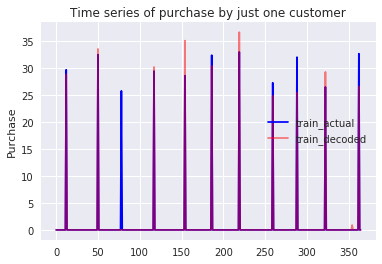

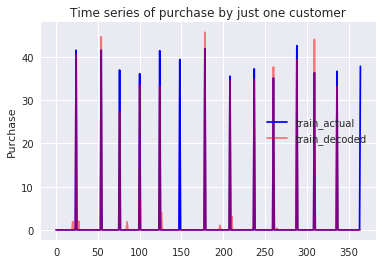

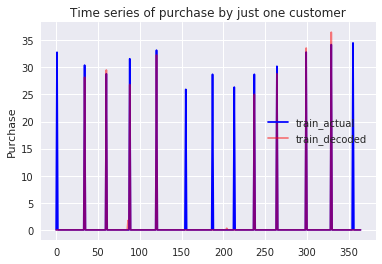

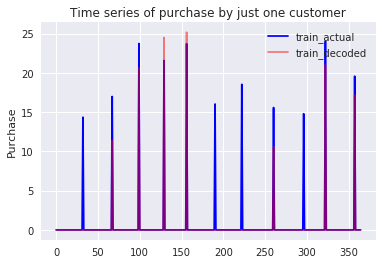

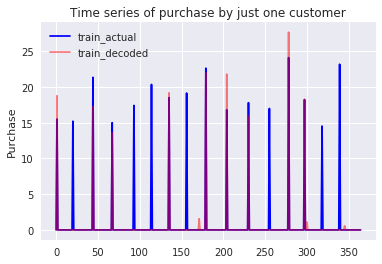

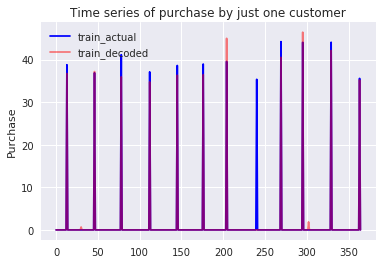

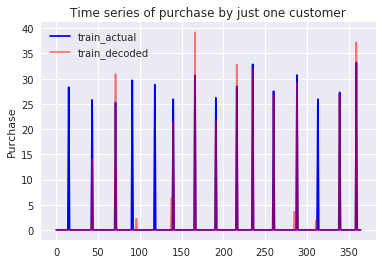

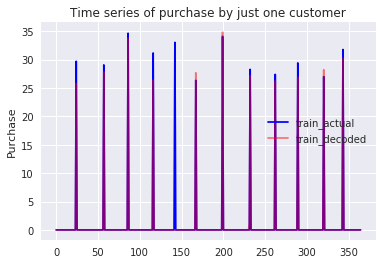

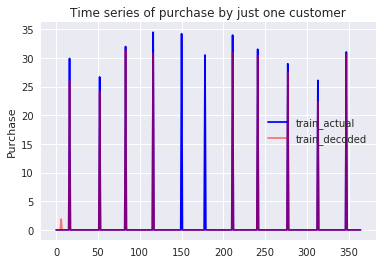

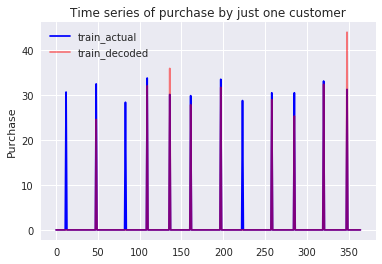

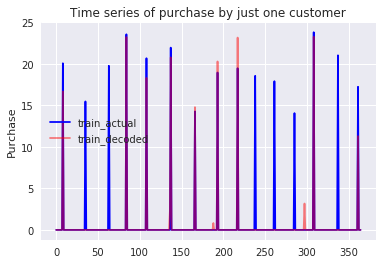

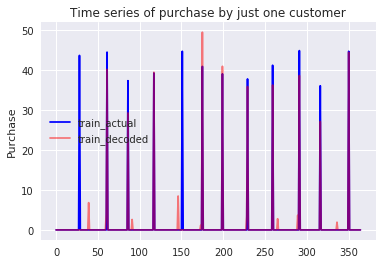

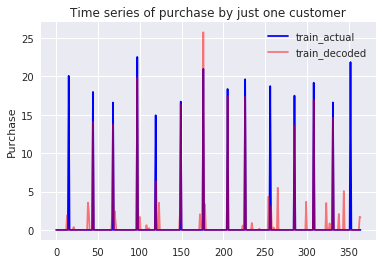

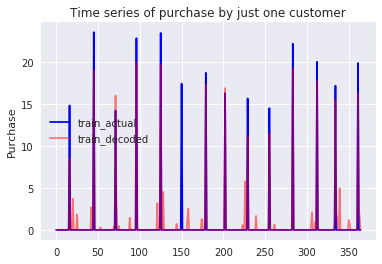

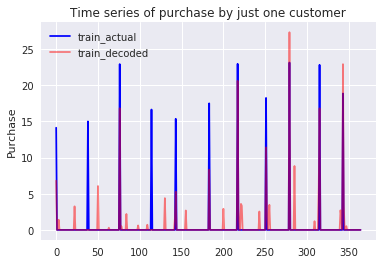

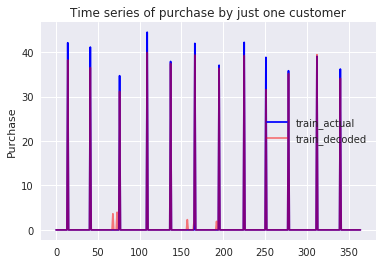

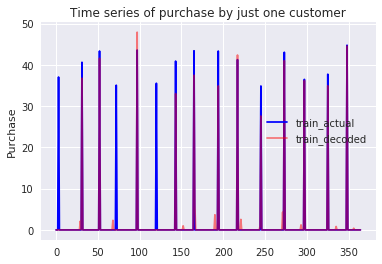

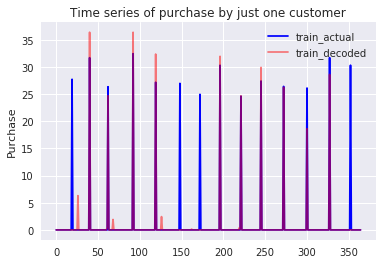

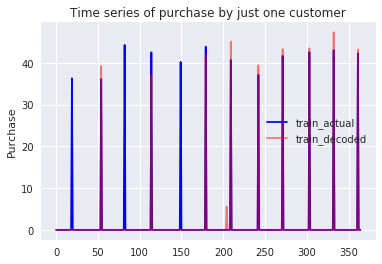

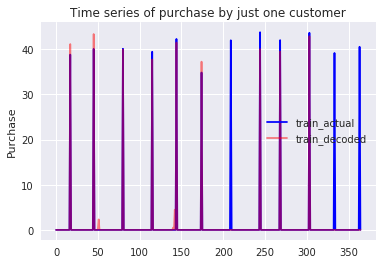

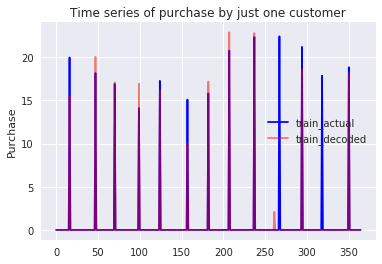

In [33]:
for i in list(xtrain.index[:25]):
    plt.title('Time series of purchase by just one customer')
    plt.plot(xtrain.loc[i,:], color = 'blue', label = 'train_actual')
    plt.plot(comparison.loc[i,:], color = 'red', label = 'train_decoded', alpha=0.5)
    plt.legend(loc='best')
    plt.ylabel('Purchase')
    plt.show()

In [34]:
xtrain_t = xtrain.T

In [35]:
start = time.time()
#validation_number = int(input("Enter the percentage validation number:"))

for validation_number in [60,120,180,240,300,360,420,480,540]:
    all_score = []
    for test_customer in xtrain_t.columns[-10:]:
        sample_series = []
        for i in range(18):
            sample_series.append(pd.DataFrame(xtrain_t[test_customer]))

        total_donor_pool = pd.DataFrame({test_customer:xtrain_t[test_customer]})

        np.random.seed(216)

        def simulator(n, j, i, k):
            for l in range(20):
                n['Offset'] = pd.DataFrame({'Offset':[random.randint(j[0], j[1]) for x in range(len(n))]})
                offset_data = n[n[test_customer] != 0]
                offset_index = offset_data.sample(int(np.ceil(i*len(offset_data)/100))).index
                new_customer = list(n[test_customer])
                for m in offset_index:
                    sign = random.choice([-1, 1])
                    if sign == 1:
                        temp1 = n[test_customer][m].copy()
                        new_customer[m] = 0
                        new_customer[max((m-n.Offset[m]),0)] = temp1
                    else:
                        temp2 = n[test_customer][m].copy()
                        new_customer[m] = 0
                        new_customer[min((m+n.Offset[m]), 364)] = temp2
                for p in range(len(new_customer)):
                    new_customer[p] = new_customer[p]*np.round(random.gauss(k,0.05),2)
                n['customer-%s-%s-%s-%s-%s'%(l,k,i, j[0], j[1])] = pd.DataFrame({'customer-%s-%s-%s-%s-%s'%(l,k,i, j[0],j[1]):new_customer})

            return n

        def con_simulator(n, j, i, k):
            for c in range(20):
                a = random.randint(j[0], j[1])
                n['Offset'] = pd.DataFrame({'Offset':[a for x in range(len(n))]})
                sign = random.choice([-1, 1])
                offset_data = n[n[test_customer] != 0]
                offset_index = offset_data.sample(int(np.ceil(random.randint(80,90)*len(offset_data)/100))).index
                new_customer = list(n[test_customer])
                for m in offset_index:
                    #sign = random.choice([-1, 1])
                    if sign == 1:
                        temp1 = n[test_customer][m].copy()
                        new_customer[m] = 0
                        new_customer[max((m-n.Offset[m]),0)] = temp1
                    else:
                        temp2 = n[test_customer][m].copy()
                        new_customer[m] = 0
                        new_customer[min((m+n.Offset[m]), 364)] = temp2
                for p in range(len(new_customer)):
                    new_customer[p] = new_customer[p]*np.round(random.gauss(k,0.05),2)
                n['customer_con_off-%s-%s-%s-%s-%s'%(c,k,i, j[0], j[1])] = pd.DataFrame({'customer_con_off-%s-%s-%s-%s-%s'%(c,k,i, j[0],j[1]):new_customer})
            return n

        for i,n in [[5,sample_series[0]]]:
            for j in [[1,3]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[5,sample_series[1]]]:
            for j in [[4,7]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[5,sample_series[2]]]:
            for j in [[8,14]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[20,sample_series[3]]]:
            for j in [[1,3]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[20,sample_series[4]]]:
            for j in [[4,7]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[20,sample_series[5]]]:
            for j in [[8,14]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[40, sample_series[6]]]:
            for j in [[1,3]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[5, sample_series[7]]]:
            for j in [[1,3]]:
                for k in [1, 0.8, 0.6]:
                    n = con_simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[40, sample_series[8]]]:
            for j in [[4,7]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[40, sample_series[9]]]:
            for j in [[8,14]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[60,sample_series[10]]]:
            for j in [[1,3]]:
                for k in [1,0.8,0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[80, sample_series[11]]]:
            for j in [[1,3]]:
                for k in [1,0.8,0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[60,sample_series[12]]]:
            for j in [[4,7]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[5, sample_series[13]]]:
            for j in [[4,7]]:
                for k in [1, 0.8, 0.6]:
                    n = con_simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[80, sample_series[14]]]:
            for j in [[4,7]]:
                for k in [1,0.8,0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[5, sample_series[15]]]:
            for j in [[8,14]]:
                for k in [1, 0.8, 0.6]:
                    n = con_simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[60,sample_series[16]]]:
            for j in [[8,14]]:
                for k in [1,0.8,0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[80, sample_series[17]]]:
            for j in [[8,14]]:
                for k in [1,0.8,0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        all_donors = total_donor_pool.T.values
        encoding = encoder.predict(np.where(all_donors>0,1,0))

        encoding_df = pd.DataFrame(encoding)
        encoding_df.insert(loc=0, column='id', value=total_donor_pool.columns.values)
        encoding_df = encoding_df.set_index(encoding_df.id).drop(labels = ['id'], axis = 1)
        encoding_df.head()

        score = []
        for i in range(len(encoding_df)):
            score.append(scipy.spatial.distance.euclidean(encoding_df.iloc[0,:], encoding_df.iloc[i,:]))

        distance = pd.DataFrame({'distance':score}, index = encoding_df.index)
        encoding_df = encoding_df.join(distance).sort_values(by='distance', ascending=True)


        final_donor_pool = encoding_df.T.columns[:validation_number]
        initial_donor_pool = total_donor_pool.columns[:validation_number]

        #initial_donor_pool = sample_series[alpha].drop(labels = [test_customer, 'Offset'], axis = 1).columns
        similarity = 0
        for i in initial_donor_pool:
            if i in final_donor_pool:
                similarity+=1
            else:
                similarity+=0

        all_score.append(np.round(similarity/len(initial_donor_pool),2)*100)

    #print('Creation time =', (time.time()-start)/60, 'minutes')    
    print('Mean score architecture 2 =', np.mean(all_score))
    #all_score_df = pd.DataFrame({'Customer':xtrain_t.columns[-10:], 'score':all_score})

Mean score architecture 2 = 39.2
Mean score architecture 2 = 72.8
Mean score architecture 2 = 98.9
Mean score architecture 2 = 84.9
Mean score architecture 2 = 88.5
Mean score architecture 2 = 97.1
Mean score architecture 2 = 91.5
Mean score architecture 2 = 83.6
Mean score architecture 2 = 85.8


In [36]:
def levenshtein(s1,s2): 
    if len(s1) > len(s2):
        s1,s2 = s2,s1 
    distances = range(len(s1) + 1) 
    for index2,char2 in enumerate(s2):
        newDistances = [index2+1]
        for index1,char1 in enumerate(s1):
            if char1 == char2:
                newDistances.append(distances[index1]) 
            else:
                newDistances.append(1 + min((distances[index1], distances[index1+1], newDistances[-1]))) 
        distances = newDistances 
    return distances[-1]

print(levenshtein(final_donor_pool, initial_donor_pool))

532
